# Imports

In [1]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import datetime as dt
#from time import gmtime, strftime 

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

# Reflect Tables into SQLAlchemy ORM

In [2]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
# Use the Inspector to explore the hawaii database and print the table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [4]:
# Use Inspector to print the column names and types for 'measurement' table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [5]:
# view few rows of 'measurement' table
engine.execute('SELECT * FROM measurement LIMIT 3').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0)]

In [6]:
# Use Inspector to print the column names and types for 'station' table
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [7]:
# view few rows of 'station' table
engine.execute('SELECT * FROM station LIMIT 3').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)]

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [40]:
# Calculate the date 1 year ago from the last data point in the database

results =session.query(Measurement.date).order_by(Measurement.date.desc())
lastDate =results[0][0]
print(lastDate)

2017-08-23


In [39]:
# convert string YYYY-MM-DD to date format  
lastDate_dt = dt.date(int(lastDate[0:4]), int(lastDate[5:7]), int(lastDate[8:10]) ) 
date_1yr_ago = lastDate_dt -dt.timedelta(days =365)
date_1yr_ago

datetime.date(2016, 8, 23)

In [13]:
# Perform a query to retrieve the data and precipitation scores
results =session.query(Measurement.date, Measurement.prcp).group_by(Measurement.date).\
            filter(Measurement.date >= date_1yr_ago).all()

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp12mo_df =pd.DataFrame(results)
prcp12mo_df.set_index("date", inplace = True) 

# Sort the dataframe by date
prcp12mo_df = prcp12mo_df.sort_values(by ='date')
prcp12mo_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


[]

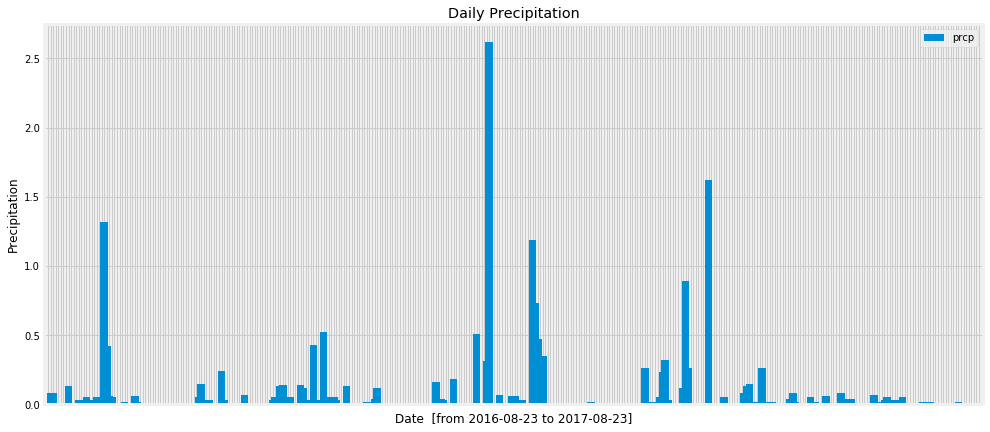

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = prcp12mo_df.plot.bar(figsize=(15,7), width=3, title='Daily Precipitation')

plt.tick_params(axis='x', labelsize=1)
ax.set_ylabel('Precipitation')
ax.set_xlabel('Date  [from 2016-08-23 to 2017-08-23]')
ax.set_xticklabels([])

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp12mo_df.describe()

,prcp
count,364.000000
mean,0.048709
std,0.204930
min,0.000000
25%,0.000000
50%,0.000000
75%,0.020000
max,2.620000


In [17]:
# Design a query to show how many stations are available in this dataset?
no_of_stations =session.query(Station.station).distinct().count()
print(f'Number of stations in dataset: {no_of_stations}') 

Number of stations in dataset: 9


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

meas_query =session.query(Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).all()  
meas_df =pd.DataFrame(meas_query)
#take only rows where prcp is finite:
meas_df = meas_df[np.isfinite(meas_df['prcp'])]

meas1_df = meas_df.drop(["date", "tobs"], axis = 1, inplace = False).rename(columns = {'prcp':'COUNTS'}, inplace = False)
sorted_stations =meas1_df.groupby('station').count().sort_values('COUNTS', ascending=False)

#Stations sorted by rows -excluding rows with NaNs
sorted_stations  

,COUNTS
station,
USC00519281,2772
USC00513117,2696
USC00519397,2685
USC00519523,2572
USC00516128,2484
USC00514830,1937
USC00511918,1932
USC00517948,683
USC00518838,342


In [19]:
# Using the station id from the previous query, calculate: 
#      the lowest temperature recorded, 
#      highest temperature recorded, and average temperature most active station?
mostactive_st =sorted_stations.reset_index()['station'][0]
mostactive_st

'USC00519281'

In [20]:
# Min temp
Tmin = meas_df.loc[meas_df['station'] == mostactive_st].min()['tobs']
print(f'Lowest temp measured by most active station (last 12 months): {Tmin} deg F.') 

# Max temp
Tmax= meas_df.loc[meas_df['station'] == mostactive_st].max()['tobs']
print(f'Largest temp measured by most active station (last 12 months): {Tmax} deg F.') 

# Avg temp
Tavg =meas_df.loc[meas_df['station'] == mostactive_st].mean()['tobs']
print(f'Average temp measured by most active station (last 12 months): {Tavg} deg F.') 

Lowest temp measured by most active station (last 12 months): 54.0 deg F.
Largest temp measured by most active station (last 12 months): 85.0 deg F.
Average temp measured by most active station (last 12 months): 71.66378066378067 deg F.


In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Note: station with the highest number of temperature observations = most active station

# ------------ STEP 1: find date 12 months ago
results =session.query(Measurement.date).filter(Measurement.station == mostactive_st).order_by(Measurement.date.desc())
lastDate = results[0][0]  
# convert string YYYY-MM-DD to date format  
lastDate_dt = dt.date(int(lastDate[0:4]), int(lastDate[5:7]), int(lastDate[8:10]) ) 
date_12mo_ago = lastDate_dt -dt.timedelta(days =365)
print(date_12mo_ago)

2016-08-18


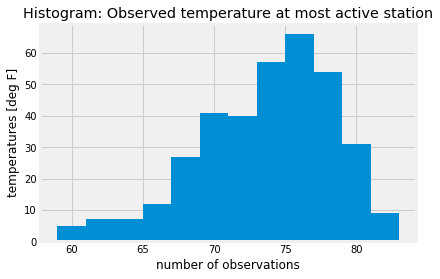

In [22]:
# ------------ STEP 2: query temps and plot histogram
temps =session.query(Measurement.tobs).filter(Measurement.station == mostactive_st).\
            filter(Measurement.date > date_12mo_ago).all()

#from list to array
atemps = np.asarray(temps)  

# plot histgram
plt.hist(atemps, bins=12)

plt.xlabel('number of observations')
plt.ylabel('temperatures [deg F]')
plt.title('Histogram: Observed temperature at most active station')

plt.show()

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

TripTemp =calc_temps('2016-12-20', '2016-12-31')

print(f'Expected min/average/max temps during trip: {TripTemp} deg F.') 

Expected min/average/max temps during trip: [(65.0, 72.18181818181819, 78.0)] deg F.


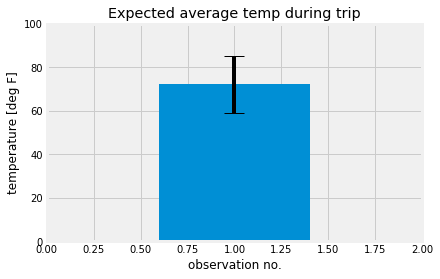

In [25]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

aTripTemp =np.ravel(TripTemp)
tmin =aTripTemp[0]
tave =aTripTemp[1]
tmax =aTripTemp[2]

plt.bar(1, tave, yerr=tmax-tmin, capsize=10)
plt.xlim(0,2)
plt.ylim(0,100)

plt.xlabel('observation no.')
plt.ylabel('temperature [deg F]')
plt.title('Expected average temp during trip')
#plt.tight_layout()
plt.show()

In [26]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# -------------------- query rain measurements
qRainSt =session.query( Measurement.station, func.sum(Measurement.prcp) ).filter(Measurement.date >= '2016-12-20').\
    filter(Measurement.date <= '2016-12-31').group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

aRainSt = np.asarray(qRainSt)  #list to array
RainSt =pd.DataFrame(aRainSt)

RainSt.rename({0:'station', 1:'total rain'}, axis=1, inplace=True)
RainSt.head()

,station,total rain
0,USC00516128,10.14
1,USC00519281,2.85
2,USC00513117,1.88
3,USC00514830,1.54
4,USC00519523,0.53


In [27]:
# -------------------- query stations 
qStat =session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).all()
Station_df =pd.DataFrame(qStat)
Station_df.head()

,station,name,latitude,longitude,elevation
0,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [28]:
# mergin station and rain measuremnts
merged = pd.merge(RainSt, Station_df, how='left', left_on='station', right_on='station')

# Shown below (in descending order by precipitation amount): station, name, latitude, longitude, elevation
merged.head()

,station,total rain,name,latitude,longitude,elevation
0,USC00516128,10.14,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00519281,2.85,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00513117,1.88,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00514830,1.54,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
4,USC00519523,0.53,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5


## Optional Challenge Assignment

In [29]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("10-01")

[(69.0, 75.22916666666667, 80.0)]

In [30]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
date1 = dt.date(2016, 12, 20)
date2 = dt.date(2017, 1, 1)    # notice end date+1 !!

# Use the start and end date to create a range of dates
def perdelta(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta
        
# Strip off the year and save a list of %m-%d strings
dateList =[]
for result in perdelta(date1, date2, dt.timedelta(days=1)):
    strg = '{:%m-%d}'.format(result)   
    dateList.append(strg)
    
print(dateList)

['12-20', '12-21', '12-22', '12-23', '12-24', '12-25', '12-26', '12-27', '12-28', '12-29', '12-30', '12-31']


In [31]:
# Loop through the list of %m-%d strings and calculate the normals for each date
normalsList =[]
for md in dateList:
    normalsList.append(daily_normals(md))
    
print(normalsList)

[[(65.0, 72.91304347826087, 81.0)], [(67.0, 72.13953488372093, 78.0)], [(67.0, 71.1304347826087, 77.0)], [(61.0, 70.34693877551021, 78.0)], [(62.0, 70.0625, 78.0)], [(60.0, 71.75, 79.0)], [(63.0, 71.44680851063829, 77.0)], [(62.0, 71.91666666666667, 79.0)], [(62.0, 70.52083333333333, 77.0)], [(57.0, 70.29166666666667, 78.0)], [(63.0, 69.86363636363636, 76.0)], [(56.0, 68.27906976744185, 77.0)]]


In [32]:
# remove [] for each element in list
out1 = [item for t in normalsList for item in t]
print(out1)

[(65.0, 72.91304347826087, 81.0), (67.0, 72.13953488372093, 78.0), (67.0, 71.1304347826087, 77.0), (61.0, 70.34693877551021, 78.0), (62.0, 70.0625, 78.0), (60.0, 71.75, 79.0), (63.0, 71.44680851063829, 77.0), (62.0, 71.91666666666667, 79.0), (62.0, 70.52083333333333, 77.0), (57.0, 70.29166666666667, 78.0), (63.0, 69.86363636363636, 76.0), (56.0, 68.27906976744185, 77.0)]


In [33]:
# remove () for each element in list
out2 = [item for t in out1 for item in t]
print(out2)

[65.0, 72.91304347826087, 81.0, 67.0, 72.13953488372093, 78.0, 67.0, 71.1304347826087, 77.0, 61.0, 70.34693877551021, 78.0, 62.0, 70.0625, 78.0, 60.0, 71.75, 79.0, 63.0, 71.44680851063829, 77.0, 62.0, 71.91666666666667, 79.0, 62.0, 70.52083333333333, 77.0, 57.0, 70.29166666666667, 78.0, 63.0, 69.86363636363636, 76.0, 56.0, 68.27906976744185, 77.0]


In [34]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
np_array =np.asarray(out2)
reshaped_array = np_array.reshape(12, 3)

normals_df =pd.DataFrame(reshaped_array, columns =['min','avg','max'])
normals_df['date'] = dateList
normals_df.index = normals_df.date
normals_df = normals_df.drop('date', 1);

# display
normals_df.head(15)

,min,avg,max
date,,,
12-20,65.0,72.913043,81.0
12-21,67.0,72.139535,78.0
12-22,67.0,71.130435,77.0
12-23,61.0,70.346939,78.0
12-24,62.0,70.062500,78.0
12-25,60.0,71.750000,79.0
12-26,63.0,71.446809,77.0
12-27,62.0,71.916667,79.0
12-28,62.0,70.520833,77.0


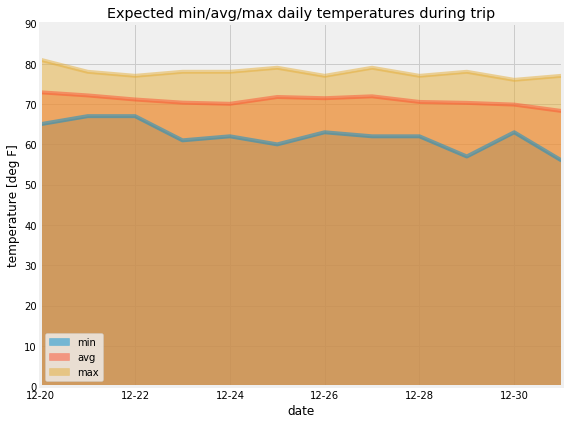

In [36]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked =False, figsize =(8,6), grid=True) 
plt.ylim(0,90)

plt.xlabel('date')
plt.ylabel('temperature [deg F]')
plt.title('Expected min/avg/max daily temperatures during trip')
plt.tight_layout()

plt.show() 